# Trend analysis in Python

Bruno Montibeller & Holger Virro

Department of Geography

University of Tartu

**Link to the repo**

## Introduction
**Aim of the workshop first**

Under the climate change threat, we need to quantify the spatio-temporal trend of temperature and rainfall patterns to understand and evaluate the potential impacts of climate change on ecosystems services, energy fluxes and biogeochemical processes. There are wide range of global or regional scale climate data freely available in a gridded format that can be used in spatio-temporal analysis studies. These data can be derived directly from satellite remote sensing data or based on reanalysis of time series of weather stations data. Additionally, some gridded data are also developed by the combination of time series of remote sensing data and weather stations data.

Different methodologies have combined spatial data sets and nonparametric statistical methods, such as the Mann-Kendall (MK) (Mann, 1945; Kendall, 1957) test, to infer about the temporal trends of climatic variables time series (Atta-ur-Rahman and Dawood, 2017; Jaagus et al., 2017; Silva Junior et al., 2018). As MK is a nonparametric test, it does not require normal distribution of the data, but it does assume no autocorrelation in the time series. The MK test has as null hypothesis that the time series has no trend, and the alternative hypothesis is that it does have a trend (upward or downward). The test first calculates the differences between all pairs of earlier and later data points in the time series. After that, it calculates the variance of these differences, which is posteriorly used to calculate the Z test value. Finally, the statistical significance of the trend is quantified by calculating the probability associated with the normalized Z test. If Z>0, it indicates an increasing trend and if Z<0 it indicates a decreasing trend. Usually, the trends are defined as significant using 95% confidence level. **graphic representation of the slope and the mm/year as slope output**

In addition to the trend calculation, it is also possible to quantify the magnitude of the trends. The magnitudes can be estimated by using the nonparametric Sen statistic, more specifically, the Sen’s Slope (SS) estimator (Sen Pranab Kumar, 1968), which is given by the median of the slopes of each pair of points. To calculate the Sen’s slope, the times series data is ordered accordingly to the time (as function of time) and a confidence interval is provided for each slope value (same as in the MK test).

**NetCDF description with image**

**Pixel-based analysis through time (image)**

**Data description**

During the workshop, the participants will learn how to handle raster datasets and apply the MK test and estimate the SS values. We will use the gridded daily temperature and daily mean temperature products from European Climate Assessment and Dataset (E-OBS version v20.0e) (Cornes et al., 2018) extracted for the three Baltic states (Estonia, Latvia and Lithuania). E-OBS is developed by interpolating climate data from weather stations provided by the national meteorological agencies of the European countries. The product is available at a grid resolution of 0.1° or 0.25°, and covers the period since 1950. For the workshop, we will use the 0.1° resolution dataset (which represents a resolution of about 10 km) from January 2000 until December 2018. ADD HERE LATER IF WE WILL WORK WITH BOTH DATASETS (TEMP AND PREC) AT MONTHLY TIME SCALE.

## Reading the NetCDF file with Xarray

We will start by importing all Python libraries used in this workshop. Data loading will be handled by **[Intake](https://intake.readthedocs.io/en/latest/)**. For data processing and wrangling we are going to use the **[Xarray](http://xarray.pydata.org/en/stable/)**, **[Pandas](https://pandas.pydata.org/)** and **[NumPy](https://numpy.org/)** libraries. **[Matplotlib](https://matplotlib.org/)** will be used for plotting purposes. Trend analysis will be carried out using the **[pyMannKendall](https://pypi.org/project/pymannkendall/)** library.

In [1]:
# Import libraries

# Data loading
import intake
import intake_xarray # Xarray wrapper for Intake
import h5netcdf

# Processing
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray # for CRS management in Xarray datasets

# Trend analysis
import pymannkendall as mk

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import collections
import matplotlib.patches as mpatches

Our temperature NetCDF is located in an ownCloud folder and the file's metadata is given in `sc58_catalog.yaml` located in the workshop's GitHub repository.

In [2]:
print('https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/sc58_catalog.yaml')

https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/sc58_catalog.yaml


Let us open the catalog file and list its content. We will use the **[Intake](https://intake.readthedocs.io/en/latest/)** library for loading the data. It allows for convenient data import from external locations.

In [3]:
# Open catalog file
cat = intake.open_catalog('https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8/sc58_catalog.yaml')
list(cat)

['monthly_precip_baltics', 'monthly_temp_baltics']

We are going to use only the temperature file named `monthly_temp_baltics.nc` in this workshop. First, let us see the metadata of this NetCDF.

In [4]:
# Read metadata
temp_data = cat.monthly_temp_baltics
temp_data

monthly_temp_baltics:
  args:
    urlpath: https://owncloud.ut.ee/owncloud/index.php/s/EHEWXe5zJSEpaDb/download
  description: Monthly temperature data for the Baltics
  driver: intake_xarray.netcdf.NetCDFSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops/main/SC5.8


The metadata includes the parameters
* `urlpath` showing the location of the NetCDF
* the `description` of the data
* `driver` to be used when importing the data
* `catalog_dir` showing the catalog file location

Now we can read the NetCDF with monthly temperature data for the Baltic states in the period 2001&ndash;2020. We are going to read the data as an Xarray dataset. The Xarray library allows for convenient manipulation of multidimensional arrays and interaction with the two main data objects&mdash;DataArray and Dataset&mdash;borrows elements from the Rasterio, Pandas and NumPy Python libraries.

Xarray is a part of the **[Pangeo](https://pangeo.io/index.html)** big data geoscience environment and is particularly useful for working with large datasets. As our dataset is not quite that big, we will only use some of the main Xarray functionalities for our analysis.

As the driver used for reading the file is already specified in the catalog, we can simply use `read` to import the temperature data.

In [5]:
# Import temperature data as an Xarray dataset
temp_ds = temp_data.read()
temp_ds

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym           (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
    spatial_ref  int32 0
Data variables:
    temp_mean    (latitude, longitude, ym) float32 nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

Our dataset has three dimensions, each of which has their own set of coordinates. The spatial dimension is made up of 57 `latitude` and 72 `longitude` coordinates, meaning that there are a total of $57\times72=4104$ unique locations with temperature information in the grid. Third dimension `ym` is an array of all 240 year&ndash;month pairs (e.g. 2001-01) covering the 20 year study period.

The fourth coordinate `spatial_ref` is not a separate dimension, but an indicator that a coordinate reference system (CRS) has been assigned to the data. The `grid_mapping` attribute of this fourth coordinate holds information about the CRS of the dataset. If we display the `attrs` property then we can see that the CRS in this case is WGS84.

In [6]:
# Display CRS information
display(temp_ds['spatial_ref'].attrs)

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': array([6378137.]),
 'semi_minor_axis': array([6356752.31424518]),
 'inverse_flattening': array([298.25722356]),
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': array([0.]),
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}

Data variable `temp_mean` contains the monthly temperature amounts of the Baltics in the period 2001&ndash;2020. Since each unique location has a time series length of 240 months, the variable contains a total of $57\times72\times240=984960$ values.

For a quick visualization of our data let us plot the temperature amount for January 2001. We can use the `sel` function and specify the specific month by using the corresponding coordinate `ym`. We also need to include the data variable `temp_mean` to our plotting call.

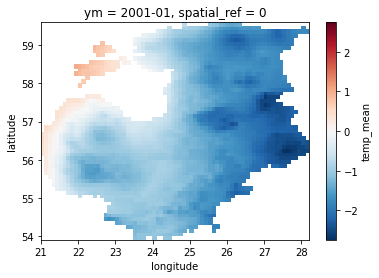

In [7]:
# Select and plot a specific month
temp_ds.sel(ym='2001-01')['temp_mean'].plot()

## Getting data ready for trend analysis

Now that we have familiarized ourselves with the dataset, let us prepare it for trend analysis.

This preprocessing phase will consist of
* Converting the Xarray Dataset into a Pandas DataFrame
* Grouping the data by location and month
* Extracting the grouped temperature values as a NumPy array

We will start by converting the dataset into a Pandas DataFrame using the corresponding function `to_dataframe`. Using `reset_index` will flatten the DataFrame, so that we have a separate row for each of our 984960 monthly temperature records.

In [8]:
# Convert the xarray to Pandas dataframe
temp_df = temp_ds.to_dataframe().reset_index() # reset_index
display(temp_df)

,latitude,longitude,ym,temp_mean,spatial_ref
0,53.949861,21.04986,2001-01,NaN,0
1,53.949861,21.04986,2001-02,NaN,0
2,53.949861,21.04986,2001-03,NaN,0
3,53.949861,21.04986,2001-04,NaN,0
4,53.949861,21.04986,2001-05,NaN,0
...,...,...,...,...,...
984955,59.549861,28.14986,2020-08,NaN,0
984956,59.549861,28.14986,2020-09,NaN,0
984957,59.549861,28.14986,2020-10,NaN,0
984958,59.549861,28.14986,2020-11,NaN,0


The input data includes a large number of missing values, indicated by `NaN` in the `temp_mean` column. These are grid cells located outside the study area (i.e. the Baltic Sea, neighboring countries).

We should remove them before moving on.

In [9]:
# Drop rows with missing temperature values
temp_df = temp_df.dropna().reset_index()
temp_df

,index,latitude,longitude,ym,temp_mean,spatial_ref
0,6000,53.949861,23.54986,2001-01,-1.155484,0
1,6001,53.949861,23.54986,2001-02,-2.777500,0
2,6002,53.949861,23.54986,2001-03,0.088065,0
3,6003,53.949861,23.54986,2001-04,8.223666,0
4,6004,53.949861,23.54986,2001-05,13.019676,0
...,...,...,...,...,...,...
611275,980635,59.549861,26.34986,2020-08,16.812258,0
611276,980636,59.549861,26.34986,2020-09,13.711668,0
611277,980637,59.549861,26.34986,2020-10,9.299999,0
611278,980638,59.549861,26.34986,2020-11,5.165666,0


Let us also split the `ym` column into separate `year` and `month` columns for more convenient grouping later on. We can use the function `split` for that and specify the delimiter in the original column.

In [10]:
# Extract year and month from the observation date as new columns
temp_df[['year', 'month']] = temp_df['ym'].str.split('-', expand=True) # expand=True tells Pandas that there are two output columns
temp_df['year'] = temp_df['year'].astype(int) # astype(int) will convert string column into integer
temp_df['month'] = temp_df['month'].astype(int)
display(temp_df)

,index,latitude,longitude,ym,temp_mean,spatial_ref,year,month
0,6000,53.949861,23.54986,2001-01,-1.155484,0,2001,1
1,6001,53.949861,23.54986,2001-02,-2.777500,0,2001,2
2,6002,53.949861,23.54986,2001-03,0.088065,0,2001,3
3,6003,53.949861,23.54986,2001-04,8.223666,0,2001,4
4,6004,53.949861,23.54986,2001-05,13.019676,0,2001,5
...,...,...,...,...,...,...,...,...
611275,980635,59.549861,26.34986,2020-08,16.812258,0,2020,8
611276,980636,59.549861,26.34986,2020-09,13.711668,0,2020,9
611277,980637,59.549861,26.34986,2020-10,9.299999,0,2020,10
611278,980638,59.549861,26.34986,2020-11,5.165666,0,2020,11


In order to make sure that the monthly temperature values end up in the correct order during grouping we should sort the DataFrame by year and month. This can be done using the `sort_values` function.

In [11]:
# Sort the DataFrame by year and month in ascending order
temp_df.sort_values(['year', 'month'], ascending=[True, True], inplace=True)

Now we can aggregate the DataFrame by location and month. We will use `groupby` to determine the columns used for grouping and assign `temp_mean` as the target column.

Pandas function `apply` can be used for applying different functions rowwise in a DataFrame. In this case, we use parameter `np.array` to tell `apply` to collect the grouped temperature values into a NumPy array for each location.

In [12]:
# Group locations by month and collect observation values to NumPy array
temp_group_df = temp_df\
    .groupby(['latitude', 'longitude', 'month'])['temp_mean']\
    .apply(np.array)\
    .reset_index() # flatten the DataFrame
display(temp_group_df)

,latitude,longitude,month,temp_mean
0,53.949861,23.54986,1,"[-1.155484, -1.569032, -5.0525813, -6.9348392,..."
1,53.949861,23.54986,2,"[-2.7775, 2.2021434, -6.039285, -1.8844824, -5..."
2,53.949861,23.54986,3,"[0.08806454, 3.3738706, 0.8622579, 1.8580645, ..."
3,53.949861,23.54986,4,"[8.223666, 8.266, 5.5366664, 7.551, 7.8069997,..."
4,53.949861,23.54986,5,"[13.019676, 15.822902, 14.108708, 10.822258, 1..."
...,...,...,...,...
30559,59.549861,26.34986,8,"[15.805161, 18.406773, 16.10516, 17.048388, 16..."
30560,59.549861,26.34986,9,"[12.335667, 11.58, 11.987667, 12.545667, 13.21..."
30561,59.549861,26.34986,10,"[8.4554825, 1.8396775, 4.703548, 6.5590324, 7...."
30562,59.549861,26.34986,11,"[0.766, -1.2219999, 2.9746668, 0.9679999, 3.94..."


We could technically also use `apply` to conduct our trend analysis in the same DataFrame. However, applying more advanced operations rowwise in large DataFrames consumes a lot of memory and can be a slow process.

For this reason, it is optimal to convert the `temp_mean` column into a NumPy array of arrays, which is a more computer friendly data structure. Each array in this big nested array consists of 20 years worth of temperature values for a particular month and location.

The order of records will be retained, so we can later add the trend analysis results back to the DataFrame.

In [13]:
# Extract temperature column as an array of arrays
temp_array = temp_group_df['temp_mean'].to_numpy()
display(temp_array)
print('Length of monthly array: ' + str(len(temp_array[0]))) # size of each monthly array

array([array([ -1.155484  ,  -1.569032  ,  -5.0525813 ,  -6.9348392 ,
        -0.04483882,  -7.9774194 ,   1.5177417 ,  -0.8593547 ,
        -3.7196774 , -10.487097  ,  -2.7848382 ,  -3.04      ,
        -5.996774  ,  -5.3016133 ,  -0.33290324,  -5.7196774 ,
        -4.384839  ,  -1.638387  ,  -4.256451  ,   2.0070968 ],
      dtype=float32),
       array([-2.7775    ,  2.2021434 , -6.039285  , -1.8844824 , -5.0989294 ,
       -6.4889283 , -5.198571  ,  1.873793  , -2.8374999 , -4.0032144 ,
       -7.0396423 , -9.015171  , -1.2635714 , -0.08214277, -0.31107143,
        1.7431031 , -2.071071  , -5.0057144 ,  1.7217857 ,  2.5710347 ],
      dtype=float32),
       array([ 0.08806454,  3.3738706 ,  0.8622579 ,  1.8580645 , -2.7787097 ,
       -3.184516  ,  5.485807  ,  2.400968  ,  0.91096765,  0.9558066 ,
        0.2806452 ,  2.2122579 , -4.105484  ,  4.987097  ,  4.276452  ,
        2.304839  ,  4.484516  , -1.4022583 ,  3.907742  ,  3.8180647 ],
      dtype=float32),
       ...,
       

Length of monthly array: 20


## Trend analysis using the Mann-Kendall (MK) test

Now we have the temperature data in an array and can move on with the trend analysis. We are going to use the [pyMannKendall](https://pypi.org/project/pymannkendall/) library for that.

Although there are 13 different versions of the MK test available in pyMannKendall, the `original_test` will suffice for now. We will apply the test to every array in `temp_array` by looping through them. Confidence level&mdash;0.05 in our case&mdash;can be assigned with parameter `alpha`.

The test will return a tuple containing the named parameters
* **trend:** tells the trend (increasing, decreasing or no trend)
* **h:** True (if trend is present) or False (if the trend is absence)
* **p:** p-value of the significance test
* **z:** normalized test statistics
* **Tau:** Kendall Tau
* **s:** Mann-Kendal's score
* **var_s:** Variance S
* **slope:** Theil-Sen estimator/slope
* **intercept:** intercept of Kendall-Theil Robust Line

For our purposes, we will only extract parameters `trend`, `p` and `slope`, which we collect into the dictionary `temp_dict`.

In [14]:
# Create a dictionary of test parameters
temp_dict = {}
temp_dict['trend'] = []
temp_dict['slope'] = []
temp_dict['p'] = []

# Iterate over arrays
for array in temp_array:
    result = mk.original_test(array, alpha=0.05) # apply the MK test to array
    temp_dict['trend'].append(result.trend) # append trend class to dictionary
    temp_dict['slope'].append(result.slope) # append slope value to dictionary
    temp_dict['p'].append(result.p) # append p value to dictionary

As the order of arrays was the same as in `temp_group_df` we can add the MK test results as new columns in the grouped DataFrame.

In [15]:
# Add test results as new columns to the DataFrame
temp_group_df['trend'] = temp_dict['trend']
temp_group_df['p'] = temp_dict['p']
temp_group_df['slope'] = temp_dict['slope']
display(temp_group_df)

,latitude,longitude,month,temp_mean,trend,p,slope
0,53.949861,23.54986,1,"[-1.155484, -1.569032, -5.0525813, -6.9348392,...",no trend,0.974118,0.039973
1,53.949861,23.54986,2,"[-2.7775, 2.2021434, -6.039285, -1.8844824, -5...",no trend,0.229969,0.251141
2,53.949861,23.54986,3,"[0.08806454, 3.3738706, 0.8622579, 1.8580645, ...",no trend,0.229969,0.135081
3,53.949861,23.54986,4,"[8.223666, 8.266, 5.5366664, 7.551, 7.8069997,...",no trend,0.770288,0.012048
4,53.949861,23.54986,5,"[13.019676, 15.822902, 14.108708, 10.822258, 1...",no trend,0.974118,0.000922
...,...,...,...,...,...,...,...
30559,59.549861,26.34986,8,"[15.805161, 18.406773, 16.10516, 17.048388, 16...",no trend,0.721176,0.018852
30560,59.549861,26.34986,9,"[12.335667, 11.58, 11.987667, 12.545667, 13.21...",no trend,0.074353,0.066889
30561,59.549861,26.34986,10,"[8.4554825, 1.8396775, 4.703548, 6.5590324, 7....",no trend,0.537603,0.042174
30562,59.549861,26.34986,11,"[0.766, -1.2219999, 2.9746668, 0.9679999, 3.94...",no trend,0.074353,0.129285


We can use Pandas function `value_counts` to display how many grid cells ended up in each of the trend classes.

In [16]:
# Display basic statistics
display(temp_group_df['trend'].value_counts())

no trend      26319
increasing     4134
decreasing      111
Name: trend, dtype: int64

We can see that a large majority of locations did not show a significant trend during the study period as
* 26319 cells indicated no trend
* 4134 cells had an increasing trend
* 111 cells had a decreasing trend

Next we will convert the parameter `trend` into a new numeric column as it will be useful when plotting later on.

Let us first create a function that assigns a new numeric trend class based on `p` and `slope`. Negative significant trends will be indicated by **-1**, positive trends by **1** and **0** will be assigned to locations where no trend was detected.

In [17]:
# Function for numeric trend conversion
def numeric_trend(slope, p):
    if slope < 0 and p < 0.05:
        return -1
    elif slope > 0 and p < 0.05:
        return 1
    else:
        return 0

Now we can use `apply` and its `lambda` parameter to generate the `numeric_trend` column. The `lambda` parameter is useful for applying a function to each row.

In our case, we are taking the values of columns `slope` and `p` for each row as input parameters for our function `numeric_trend`, which we created in the last step. Parameter `axis=1` will tell the function that we are iterating over rows rather than columns.

Some examples of `lambda` use can be found at [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html).

In [18]:
# Create a numeric version of the trend column
temp_group_df['numeric_trend'] = temp_group_df.apply(lambda x: numeric_trend(x['slope'], x['p']), axis=1)
display(temp_group_df.sample(10))
display(temp_group_df['numeric_trend'].value_counts())

,latitude,longitude,month,temp_mean,trend,p,slope,numeric_trend
12556,56.349861,24.34986,5,"[12.280967, 14.925807, 13.316128, 10.968062, 1...",no trend,0.537603,-0.042930,0
11433,56.249861,22.14986,10,"[9.363869, 3.6474192, 4.802258, 7.6048384, 7.8...",no trend,0.074353,0.139842,0
11300,56.249861,21.04986,9,"[12.858333, 13.594333, 13.667334, 14.494666, 1...",no trend,0.064411,0.081861,0
28787,59.149861,24.54986,12,"[-7.022258, -7.5190315, 0.39451614, 0.56193554...",no trend,0.229969,0.138891,0
17179,56.849861,27.64986,8,"[16.863546, 18.84387, 15.494514, 17.499678, 16...",no trend,0.721176,0.006154,0
20094,57.349861,22.84986,7,"[19.596775, 18.550968, 20.110325, 16.033546, 1...",no trend,0.581255,-0.066781,0
26343,58.649861,25.54986,4,"[6.8426666, 6.1089993, 3.1926663, 5.8646655, 4...",no trend,0.922462,-0.013083,0
10603,56.149861,22.34986,8,"[16.97258, 19.338064, 16.58, 17.43613, 16.0712...",no trend,0.229969,0.046349,0
6431,55.549861,24.24986,12,"[-6.1870975, -8.36129, 0.6396774, 1.0322579, -...",no trend,0.127289,0.189024,0
21042,57.449861,27.34986,7,"[21.343548, 19.579676, 19.499353, 16.918064, 1...",no trend,0.074353,-0.114204,0


 0    26319
 1     4134
-1      111
Name: numeric_trend, dtype: int64

Before plotting the trend results we need to convert our DataFrame back into an Xarray Dataset. This can be done with `to_xarray`, but first we need to use `set_index` and assign an index to the DataFrame. The columns used for the index will end up as dimensions in the resulting Xarray Dataset.

Let us also assign a CRS with `write_crs` from [rioxarray](https://corteva.github.io/rioxarray/stable/), which is a supplementary Xarray library used for spatial operations.

In [19]:
# Convert the DataFrame back to xarray Dataset and assign CRS
df = temp_group_df.copy() # copy of temp_group_df
df.set_index(['latitude', 'longitude', 'month'], inplace=True)
temp_array = df.to_xarray()
temp_array.rio.write_crs('epsg:4326', inplace=True)
display(temp_array)

<xarray.Dataset>
Dimensions:        (latitude: 57, longitude: 72, month: 12)
Coordinates:
  * latitude       (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude      (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref    int32 0
Data variables:
    temp_mean      (latitude, longitude, month) object nan nan nan ... nan nan
    trend          (latitude, longitude, month) object nan nan nan ... nan nan
    p              (latitude, longitude, month) float64 nan nan nan ... nan nan
    slope          (latitude, longitude, month) float64 nan nan nan ... nan nan
    numeric_trend  (latitude, longitude, month) float64 nan nan nan ... nan nan
Attributes:
    grid_mapping:  spatial_ref

## Plotting the trend analysis results

### Plotting slopes

Finally, we can plot our results.

First, let us take a look at the spatial and temporal pattern of the `slope` parameter. This will give an idea where and when temperature has changed the most. The change will be represented in &deg;C/year.

Before plotting, let us create a list of months for the iteration.

In [20]:
# List of months used for iterating
months = temp_array['month']

For plotting monthly slope values indicating the intensity of temperature change we will create a Matplotlib figure object `fig` consisting of a $4\times3$ grid of axes.

While iterating over each of the 12 months and their corresponding axes we
* will select the corresponding dataset slice from `temp_array` using the `sel` command
* plot the slope values for that particular month

In the end we also will add a title to our plot.

Text(0.5, 1.05, 'Change in temperature (C$\\degree$/year)')

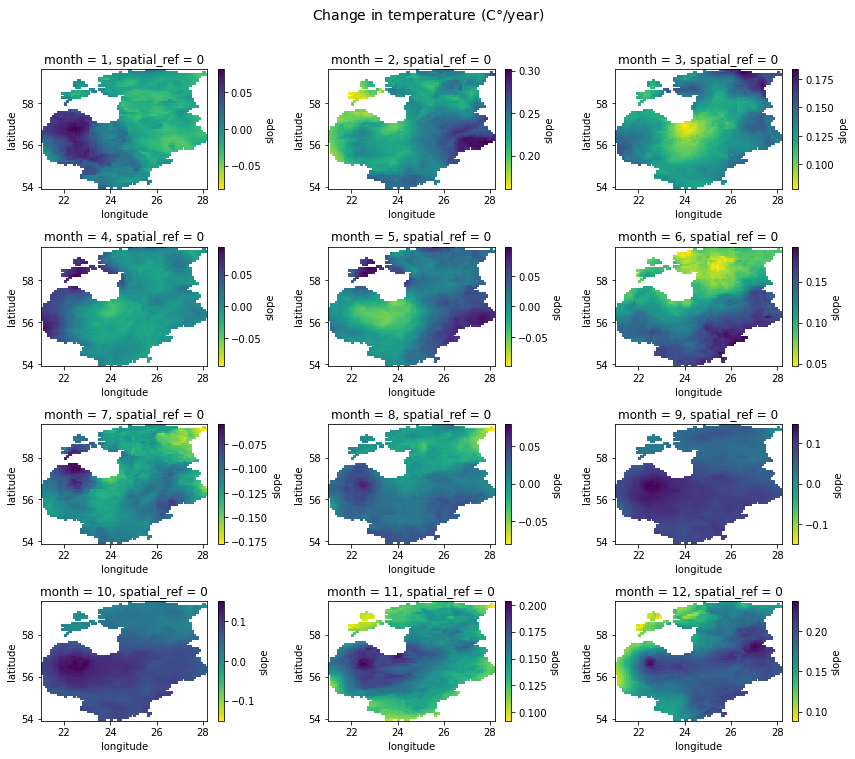

In [21]:
# Create figure and iterate over months to plot the existence of trends in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = temp_array.sel(month=month) # select the month
    ds['slope'].plot(ax=ax, cmap='viridis_r')
fig.tight_layout()

# Add the title
degree_symbol = '$\degree$'
fig_title = 'Change in temperature (C{}/year)'.format(degree_symbol)
fig.suptitle(fig_title, y=1.05, size=14)

Although we can see that changes vary in both magnitude and spatial pattern between the months, the results are difficult to compare as the subplots' colorbars have different ranges. We can improve the visualization by creating a custom colorbar for the plot.

Let us create a list of potential colorbar levels by collecting the minimum and maximum slope values for each month and rounding them to the first decimal place. We will use NumPy functions `nanmin` and `nanmax` to exclude `nan` values and use `round` to round the results to the first decimal place.

In [22]:
# List for collecting monthly minimum and maximum slope values
slopes = []

# Iterate over months and collect min and max slope values
for month in months:
    slope_values = temp_array.sel(month=month)['slope'].values
    min_slope = np.round(np.nanmin(slope_values), 1)
    max_slope = np.round(np.nanmax(slope_values), 1)
    slopes.extend([min_slope, max_slope])

print(slopes)

[-0.0, 0.1, 0.2, 0.3, 0.1, 0.2, -0.0, 0.1, -0.1, 0.1, 0.0, 0.2, -0.2, -0.1, -0.1, 0.1, -0.0, 0.1, -0.0, 0.2, 0.1, 0.2, 0.1, 0.2]


Now we can get the colorbar levels by creating a new list based on the minimum and maximum overall slope values.

In [23]:
# Create a list of colorbar levels based on slopes
step = 0.1
levels = np.arange(min(slopes), max(slopes) + step, 0.1)
print(levels)

[-0.2 -0.1  0.   0.1  0.2  0.3  0.4]


We can now recreate the plot with a custom colorbar range by specifying the `levels` parameter and telling `cbar_kwargs` to add ticks at right locations.

Text(0.5, 1.05, 'Change in temperature (C$\\degree$/year)')

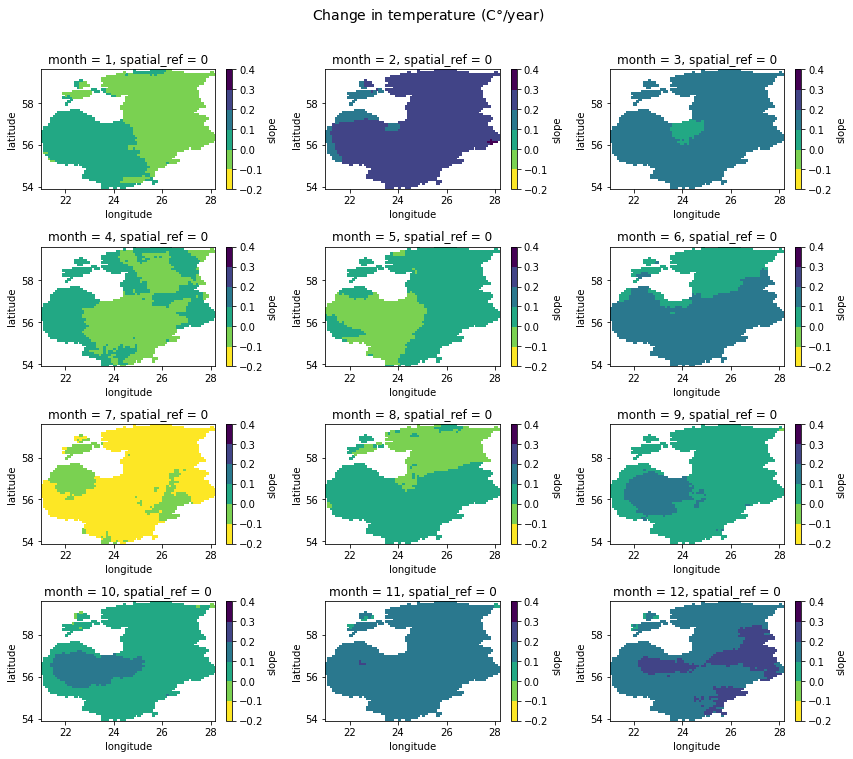

In [24]:
# Create figure and iterate over months to plot the existence of trends in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = temp_array.sel(month=month) # select the month
    ds['slope'].plot(ax=ax, cmap='viridis_r', levels=levels, cbar_kwargs={'ticks': levels})
fig.tight_layout()

# Add the title
degree_symbol = '$\degree$'
fig_title = 'Change in temperature (C{}/year)'.format(degree_symbol)
fig.suptitle(fig_title, y=1.05, size=14)

### Plotting significant trends

First, let us plot grid cells that indicated a statistically significant trend in each of the 12 months during our study period. In order to avoid generating a separate legend for each subplot we will construct a single legend manually using an `OrderedDict` object from the [collections](https://docs.python.org/3/library/collections.html) package and the `patches` submodule from Matplotlib.

As not all trend classes exist in all months, we need to also specify the range of classes in a particular month while looping, so that colors can be assigned correctly.

**Bullet points with the plotting objects**

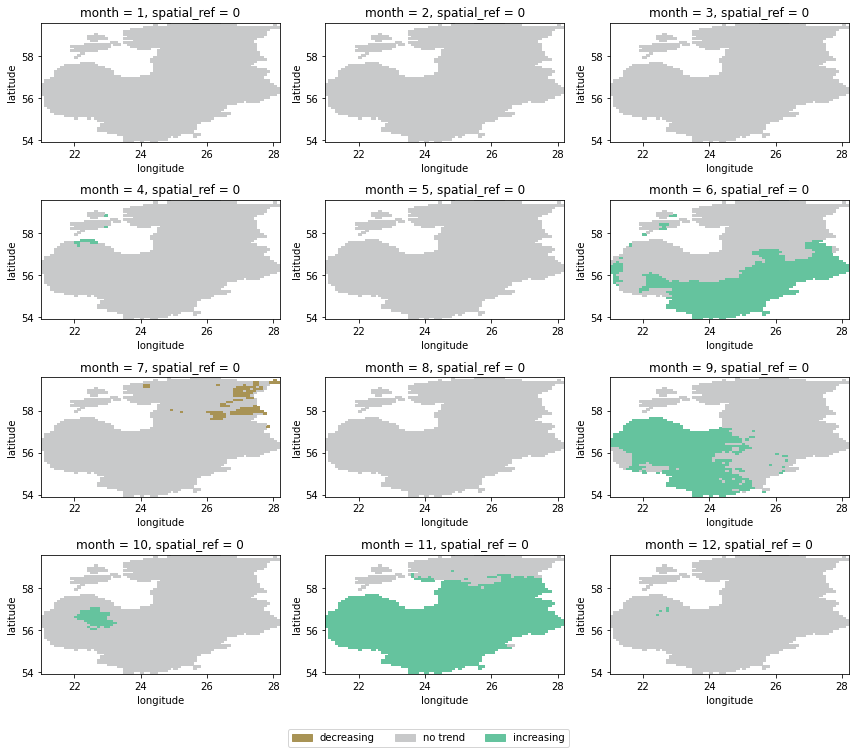

In [25]:
# Dictionary for legend elements
legend_dict = collections.OrderedDict([])

# Trend classes
trend_classes = ['decreasing', 'no trend', 'increasing']
numeric_classes = [-1, 0, 1]

# Colors used for the classes
colors = ['#A89355', '#C8C9CA', '#65C39E']

# Color dictionary
color_dict = dict(zip(numeric_classes, colors))

# Update legend with the trend classes and corresponding colors
for trend_class, color in zip(trend_classes, colors):
    legend_dict.update({trend_class: color})

# Matplotlib color patches to be used in the legend
patches = []
for trend_class in legend_dict:
    patch = mpatches.Patch(color=legend_dict[trend_class], label=trend_class)
    patches.append(patch)

# Create figure and iterate over months to plot the existence of trends in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = temp_array.sel(month=month) # select month
    levels = [] # list of classes for a particular month
    for cl in np.arange(int(ds['numeric_trend'].min().values), int(ds['numeric_trend'].max().values + 1), 1):
        levels.append(cl)
    colors = [color_dict[cl] for cl in levels]
    cmap = matplotlib.colors.ListedColormap(colors) # colormap
    ds['numeric_trend'].plot(ax=ax, cmap=cmap, add_colorbar=False) # plot
fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
fig.tight_layout()

We can see that no significant trends can be detected in most of the months. Increasing trends were detected in parts of western Lithuania and Latvia in May. Additionally, temperature has also increased along the eastern border of both countries in July. A decreasing trend can be seen in the case of November in eastern Estonia and in a few locations in western Lithuania in June and September.

The general lack of significant trends can be explained by a relatively short time series, as climate studies tend to look at longer time frames. All countries are similar in size, distance from the Atlantic ocean and terrain, which means that rainfall patterns are also relatively similar.

## References

* Atta-ur-Rahman, and Dawood, M. (2017). Spatio-statistical analysis of temperature fluctuation using Mann–Kendall and Sen’s slope approach. Clim. Dyn. 48, 783–797. doi:10.1007/s00382-016-3110-y.

* Cornes, R. C., van der Schrier, G., van den Besselaar, E. J. M., and Jones, P. D. (2018). An Ensemble Version of the E-OBS Temperature and temperature Data Sets. J. Geophys. Res. Atmos. 123, 9391–9409. doi:10.1029/2017JD028200.

* Jaagus, J., Sepp, M., Tamm, T., Järvet, A., and Mõisja, K. (2017). Trends and regime shifts in climatic conditions and river runoff in Estonia during 1951–2015. Earth Syst. Dyn. 8, 963–976. doi:10.5194/esd-8-963-2017.

* Kendall, M. G. (1957). Rank Correlation Methods. Biometrika 44, 298. doi:10.2307/2333282.

* Mann, H. B. (1945). Non-Parametric Test Against Trend. Econometrica 13, 245–259. Available at: http://www.economist.com/node/18330371?story%7B_%7Did=18330371.

* Sen Pranab Kumar (1968). Estimates of the Regression Coefficient Based on Kendall’s Tau. J. Am. Stat. Assoc. 63, 1379–1389.

* Silva Junior, C. H. L., Almeida, C. T., Santos, J. R. N., Anderson, L. O., Aragão, L. E. O. C., and Silva, F. B. (2018). Spatiotemporal rainfall trends in the Brazilian legal Amazon between the years 1998 and 2015. Water (Switzerland) 10, 1–16. doi:10.3390/w10091220.